# Capital Allocation
## 🎯 Learning Objectives

By the end of this notebook, you will be able to:

- **Formulate** the capital allocation problem for an investor maximizing expected utility
- **Derive** the mean-variance efficient (MVE) portfolio weights for risky assets
- **Understand** the two-fund separation theorem and its practical implications
- **Explain** how "all you need is Sharpe" simplifies portfolio construction
- **Implement** alpha bets and portable alpha strategies in Python

## 📋 Table of Contents

1. [Setup](#setup)
2. [The Capital Allocation Problem](#the-capital-allocation-problem)
3. [The Optimal Portfolio](#the-optimal-portfolio)
4. [Factor Data](#factor-data)
5. [All You Need Is Sharpe?](#all-you-need-is-sharpe)
6. [Mean-Variance Efficient Portfolio](#mean-variance-efficient-portfolio)
7. [Two-Fund Separation](#two-fund-separation)
8. [Alpha Bets and Portable Alpha](#alpha-bets-and-portable-alpha)
9. [Exercises](#exercises)
10. [Key Takeaways](#key-takeaways)

In [3]:
#@title 🛠️ Setup: Run this cell first <a id="setup"></a>



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [4]:
#@title 📦 Helper Function: get_factors()
import datetime
from pandas_datareader.data import DataReader
def get_factors(factors='CAPM', freq='daily'):
    """Download Fama-French factor data.

    Parameters:
    - factors: 'CAPM', 'FF3', 'FF5', or 'FF6'
    - freq: 'daily' or 'monthly'

    Returns: DataFrame with factor returns (as decimals)
    """
    freq_label = '' if freq == 'monthly' else '_' + freq

    if factors == 'CAPM':
        ff = DataReader(f"F-F_Research_Data_Factors{freq_label}", "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF']]
    elif factors == 'FF3':
        ff = DataReader(f"F-F_Research_Data_Factors{freq_label}", "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF', 'SMB', 'HML']]
    elif factors == 'FF5':
        ff = DataReader(f"F-F_Research_Data_Factors{freq_label}", "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF', 'SMB', 'HML']]
        ff2 = DataReader(f"F-F_Research_Data_5_Factors_2x3{freq_label}", "famafrench", start="1921-01-01")
        df_factor = df_factor.merge(ff2[0][['RMW', 'CMA']], on='Date', how='outer')
    else:  # FF6
        ff = DataReader(f"F-F_Research_Data_Factors{freq_label}", "famafrench", start="1921-01-01")
        df_factor = ff[0][['RF', 'Mkt-RF', 'SMB', 'HML']]
        ff2 = DataReader(f"F-F_Research_Data_5_Factors_2x3{freq_label}", "famafrench", start="1921-01-01")
        df_factor = df_factor.merge(ff2[0][['RMW', 'CMA']], on='Date', how='outer')
        ff_mom = DataReader(f"F-F_Momentum_Factor{freq_label}", "famafrench", start="1921-01-01")
        df_factor = df_factor.merge(ff_mom[0], on='Date')
        df_factor.columns = ['RF', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']

    if freq == 'monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp()) + pd.offsets.MonthEnd(0)
    else:
        df_factor.index = pd.to_datetime(df_factor.index)
    return df_factor / 100  # Convert from percent to decimal

---

## The Capital Allocation Problem <a id="the-capital-allocation-problem"></a>

Every investor faces two fundamental questions:

1. **How much risk should I take?** (Allocation between risky and risk-free)
2. **How should I spread that risk?** (Allocation across risky assets)

> **💡 Key Insight:**
>
> A fundamental insight of portfolio theory is that these two decisions are **separable**:
> 1. First, find the portfolio with the best risk-return properties
> 2. Then, decide how much to allocate to it vs. the risk-free asset

### Who Decides How Much Risk to Take?

If you're investing your own money (the **principal**), your optimal portfolio depends on:

| Factor | Examples |
|--------|----------|
| **Risk tolerance** | How terrible you feel if you have less than expected |
| **Investment horizon** | Retirement in 5 years vs. 30 years |
| **Financial goals** | Minimum retirement income, college fund, property purchase |
| **Background risk** | Other income sources, job security |

---

## The Optimal Portfolio <a id="the-optimal-portfolio"></a>

We model preferences using **mean-variance utility**:

$$\max_w \quad x \cdot E[r_p] - \frac{\gamma}{2} w^2 \cdot \text{Var}(r_p)$$

where:
- $w$ = weight on the risky portfolio
- $E[r_p]$ = expected excess return
- $\gamma$ = risk aversion coefficient
- $\text{Var}(r_p)$ = portfolio variance

Taking the derivative with respect to the weight and setting to zero:

$$w^* = \frac{1}{\gamma} \cdot \frac{E[r_p]}{\text{Var}(r_p)}$$

> **💡 Key Insight:**
>
> Your optimal weight is proportional to the **risk-return trade-off**.
>
> Your optimal volatility is:
> $$w^* \cdot \sigma(r_p) = \frac{1}{\gamma} \cdot \text{Sharpe Ratio}$$

---

## Factor Data <a id="factor-data"></a>

We'll work with the **Fama-French 6 factors**:

| Factor | Description |
|--------|-------------|
| **Mkt-RF** | Market excess return |
| **SMB** | Small minus Big (size) |
| **HML** | High minus Low (value) |
| **RMW** | Robust minus Weak (profitability) |
| **CMA** | Conservative minus Aggressive (investment) |
| **MOM** | Momentum |

In [5]:
# Load factor data
df = get_factors(factors='FF6', freq='monthly').dropna()

print(f"Data range: {df.index[0].strftime('%Y-%m')} to {df.index[-1].strftime('%Y-%m')}")
print(f"Number of months: {len(df)}")
df.head()

Data range: 1963-07 to 2025-11
Number of months: 749


,RF,Mkt-RF,SMB,HML,RMW,CMA,MOM
Date,,,,,,,
1963-07-31,0.0027,-0.0039,-0.0057,-0.0081,0.0064,-0.0115,0.0101
1963-08-31,0.0025,0.0508,-0.0095,0.0170,0.0040,-0.0038,0.0100
1963-09-30,0.0027,-0.0157,-0.0025,0.0000,-0.0078,0.0015,0.0012
1963-10-31,0.0029,0.0254,-0.0057,-0.0004,0.0279,-0.0225,0.0313
1963-11-30,0.0027,-0.0086,-0.0116,0.0173,-0.0043,0.0227,-0.0078


In [6]:
# Separate risk-free and excess returns
rf = df['RF']
factors = df.drop(columns=['RF'])

# Summary statistics (annualized)
summary = pd.DataFrame({
    'Mean (ann.)': factors.mean() * 12,
    'Vol (ann.)': factors.std() * np.sqrt(12),
    'Sharpe': (factors.mean() * 12) / (factors.std() * np.sqrt(12)),
    'Freq 3 std dev':(factors.abs()/factors.std()>3).mean()
})
summary.round(3)

,Mean (ann.),Vol (ann.),Sharpe,Freq 3 std dev
Mkt-RF,0.071,0.155,0.462,0.008
SMB,0.018,0.105,0.167,0.008
HML,0.034,0.103,0.331,0.011
RMW,0.032,0.077,0.410,0.017
CMA,0.029,0.072,0.404,0.013
MOM,0.071,0.145,0.493,0.017


---

## All You Need Is Sharpe? <a id="all-you-need-is-sharpe"></a>

The Sharpe ratio is powerful because:
- Higher SR → more growth per unit of risk
- For the same growth, you need less risk
- Higher expected growth → fewer large losses

> **⚠️ Caution:**
>
> Sharpe ratio is "all you need" **only if**:
> 1. You have mean-variance preferences
> 2. Returns are normally distributed
>

Normality
- Always check the realized tails of your portfolio—are black swans too frequent?
- How frequently 3 standard deviation events should be?

Preferences

- do you care about all returns equally?
- or is it more painfull to get a -20\% returns in some situations? (we call "states of the world")
- What are examples of situations where would eb particularly bad for you to get a really bad return?
- What about Bloomberg? Or Taylor Swift?

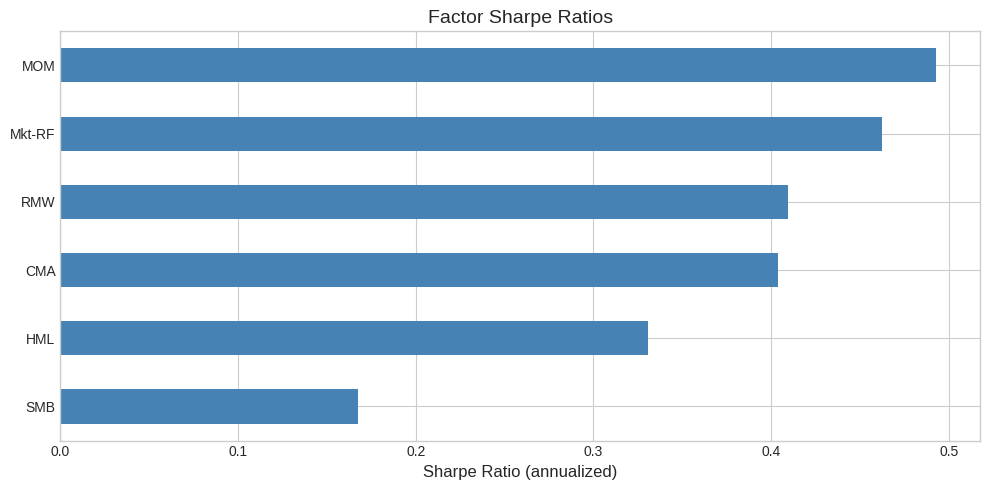

In [7]:
# Visualize the Sharpe ratios
fig, ax = plt.subplots(figsize=(10, 5))
summary['Sharpe'].sort_values().plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Sharpe Ratio (annualized)', fontsize=12)
ax.set_title('Factor Sharpe Ratios', fontsize=14)
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

## How do we combine these strategies?

- If I want the maximum return?

- If I want the maximum Sharpe Ratio?

- If I want the minimum Variance?

- If I want the maximum return given a maximum desired variance?

- If I want the minimum variance given a minimum desired return?




<details>
<summary>💡 What are the different approches we can take?</summary>


1. Pick the best asset for your criteria?

2. Grid of weights?

3. Solver?

4. Solve analytically


</details>

---

## How do we combine these strategies? <a id="mean-variance-efficient-portfolio"></a>

How do we build a portfolio that **maximizes the mean-variance criteria**?

$$ \max_W E[W'R^e]-\frac{\gamma}{2} Var(W'R^e)$$


How do we build a portfolio that **maximizes the Expected excess return given a variance budget**?

$$ \max_W E[W'R^e] \text{ subject to } Var(W'R^e)\leq \overline{V}$$


How do we build a portfolio that **maximizes the Expected excess return**?

$$ \max_W E[W'R^e]$$


How do we build a portfolio that **minimizes Variance**?

$$ \min_W Var[W'R^e]$$


How do we build a portfolio that **maximizes Sharpe Ratio**?

$$ \max_W \frac{E[W'R^e]}{\sqrt{Var[W'R^e]}}$$




### Approaches

1. Grid

2. Numerical

3. Math

What all these approaches require?


In [19]:
#@title 🛠️ Setup: Numerical Approach to portfolio maximization <a id="setup"></a>

# I implement maximum expected return given a variance buget
# it is easy to adjust to all other objectives
from scipy.optimize import minimize

def max_return_target_variance(mu_df, sigma_df, target_variance):
    """
    Solves for the maximum expected return portfolio given a cap on portfolio variance.

    Args:
        mu (pd.Series): Series of expected returns (N,).
        sigma_df (pd.DataFrame): Covariance matrix (N, N).
        target_variance (float): Maximum allowed portfolio variance.

    Returns:
        pd.Series: Optimal weights for the portfolio (N,).
    """
    mu = mu_df.to_numpy()
    Sigma = sigma_df.to_numpy()
    num_assets = len(mu)

    # Objective function: minimize negative expected return to maximize expected return
    def objective(weights):
        return -np.dot(weights, mu)

    # Constraint 1: Sum of weights must be 1 (full investment)
    # Constraint 2: Portfolio variance must be less than or equal to target_variance
    # For 'ineq' constraints, the function must return a value >= 0.
    # So, target_variance - portfolio_variance >= 0
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
         {'type': 'ineq',
        'fun': lambda weights: target_variance - np.dot(weights.T, np.dot(Sigma, weights))
    }]

    # Bounds for weights (assuming no short selling: 0 <= w_i <= 1)
    bounds = tuple((-10, 10) for _ in range(num_assets))

    # Initial guess (equal weights)
    initial_weights = np.array(num_assets * [1. / num_assets])

    # Solve the optimization problem using SLSQP (Sequential Least Squares Programming)
    result = minimize(
        objective,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if result.success:
        return pd.Series(result.x, index=mu_df.index)
    else:
        raise ValueError(f"Optimization failed: {result.message}")

target_variance_monthly = 0.1**2/12
mu=factors.mean()
Sigma=factors.cov() # how do we estimate the variance-covariance matrix between the factors?
print("Solving for max return portfolio with variance cap...")
try:
    optimal_weights_target_var = max_return_target_variance(mu, Sigma, target_variance_monthly)
    print("\nOptimal weights for max return with target variance cap:")
    display(optimal_weights_target_var.round(4))

    # Calculate portfolio statistics with the optimal weights
    portfolio_return = np.dot(optimal_weights_target_var, mu)
    portfolio_variance = np.dot(optimal_weights_target_var.T, np.dot(Sigma, optimal_weights_target_var))
    portfolio_volatility = np.sqrt(portfolio_variance)

    print(f"\nPortfolio Expected Monthly Return: {portfolio_return:.4f}")
    print(f"Portfolio Monthly Variance: {portfolio_variance:.4f} (Target: <= {target_variance_monthly:.4f})")
    print(f"Portfolio Monthly Volatility: {portfolio_volatility:.4f}")

    print("\nAnnualized statistics:")
    print(f"Portfolio Expected Annual Return: {portfolio_return * 12:.4f}")
    print(f"Portfolio Annual Volatility: {portfolio_volatility * np.sqrt(12):.4f}")

except ValueError as e:
    print(e)

Solving for max return portfolio with variance cap...

Optimal weights for max return with target variance cap:


,0
Mkt-RF,0.5168
SMB,-0.3898
HML,0.2462
RMW,0.0191
CMA,0.0536
MOM,0.5540



Portfolio Expected Monthly Return: 0.0067
Portfolio Monthly Variance: 0.0008 (Target: <= 0.0008)
Portfolio Monthly Volatility: 0.0289

Annualized statistics:
Portfolio Expected Annual Return: 0.0801
Portfolio Annual Volatility: 0.1000


---

## The Math Approach <a id="mean-variance-efficient-portfolio"></a>


$$ \max_W W'E[R^e]-\frac{\gamma}{2} W'Var(R^e) W$$

The Optimality condition is obtained by differentiating with respect to the vector W:

$$ E[R^e]-\gamma  Var(R^e) W=0$$
If we know the expected returns $E[R^e]$ and covariance matrix $Var(R^e)$, the answer is:

$$W^* = \frac{1}{\gamma} Var(R^e)^{-1} E[R^e]$$


> **🐍 Python Insight: `np.linalg.inv()`**
>
> To compute the inverse of a matrix:
> ```python
> Sigma_inv = np.linalg.inv(Sigma)
> ```
> For numerical stability with near-singular matrices, use:
> ```python
> Sigma_inv = np.linalg.pinv(Sigma)  # Pseudo-inverse
> ```
> Inverse of matrix M is the matrix that the product produce the identity $M@M^{-1}=I$
>
> For intution: for a scalar , $2*2^{-1}=1$, so $2^{-1}=1/2$

In [6]:
# Estimate moments from the sample
mu = factors.mean()  # Monthly expected returns
Sigma = factors.cov()  # Monthly covariance matrix

print("Expected excess returns (monthly):")
display(mu.round(4))
print("\nCovariance matrix:")
display(Sigma.round(6))

Expected excess returns (monthly):


,0
Mkt-RF,0.0060
SMB,0.0015
HML,0.0028
RMW,0.0026
CMA,0.0024
MOM,0.0059



Covariance matrix:


,Mkt-RF,SMB,HML,RMW,CMA,MOM
Mkt-RF,0.001991,0.000397,-0.000274,-0.000188,-0.000325,-0.000322
SMB,0.000397,0.000914,-0.000128,-0.000270,-0.000105,-0.000068
HML,-0.000274,-0.000128,0.000883,0.000060,0.000419,-0.000242
RMW,-0.000188,-0.000270,0.000060,0.000494,0.000002,0.000075
CMA,-0.000325,-0.000105,0.000419,0.000002,0.000426,-0.000014
MOM,-0.000322,-0.000068,-0.000242,0.000075,-0.000014,0.001742


In [7]:
# Compute the MVE portfolio (unscaled)
Sigma_inv = np.linalg.inv(Sigma)
W_mve = Sigma_inv @ mu

print("MVE weights (unscaled):")
pd.Series(W_mve, index=factors.columns).round(2)

MVE weights (unscaled):


,0
Mkt-RF,5.58
SMB,3.25
HML,1.82
RMW,8.28
CMA,9.04
MOM,4.54


In [8]:
# Compute MVE portfolio statistics
mve_return = W_mve @ mu  # Monthly
mve_var = W_mve @ Sigma @ W_mve  # Monthly
mve_vol = np.sqrt(mve_var)
mve_sharpe = (mve_return * 12) / (mve_vol * np.sqrt(12))

print(f"MVE Portfolio (annualized):")
print(f"  Expected return: {mve_return * 12:.2%}")
print(f"  Volatility: {mve_vol * np.sqrt(12):.2%}")
print(f"  Sharpe ratio: {mve_sharpe:.2f}")

MVE Portfolio (annualized):
  Expected return: 136.35%
  Volatility: 116.77%
  Sharpe ratio: 1.17


---

## Two-Fund Separation <a id="two-fund-separation"></a>


The **maximum Sharpe ratio portfolio** is given by:
$$W_{SR} = Var(R^e)^{-1} E[R^e]$$

This portfolio is also called:

- MVE (Mean-Variance Efficient) portfolio (why?)
- Tangency portfolio (why?)



> **💡 Key Insight: Leverage does not change Sharpe Ratio**
>$$SR(lW'R)=\frac{lE[W'R]}{\sigma(lW'R)}=\frac{E[W'R]}{\sigma(W'R)}$$
>
> This implies that if $W$ is MVE, $lW$ is also MVE for any l>0
>


> **💡 Key Insight: Two-Fund Separation**
>
> All investors—regardless of risk aversion—hold the **same risky portfolio**!
> - he scalar $\frac{1}{\gamma}$ just levers/delevers the portfolio.
> - Risk-averse investor: Small position in MVE + large position in risk-free
> - Risk-tolerant investor: Large (possibly leveraged) position in MVE
>
> They differ only in **how much**, not **what**.

In [9]:
# Trace the investment frontier (Capital Market Line)
leverage_values = np.linspace(0, 3, 100)

frontier = []
for lev in leverage_values:
    W = lev * W_mve
    er = (W @ mu) * 12  # Annualized
    vol = np.sqrt(W @ Sigma @ W) * np.sqrt(12)  # Annualized
    frontier.append([lev, vol, er])

frontier = pd.DataFrame(frontier, columns=['Leverage', 'Volatility', 'Expected_Return'])

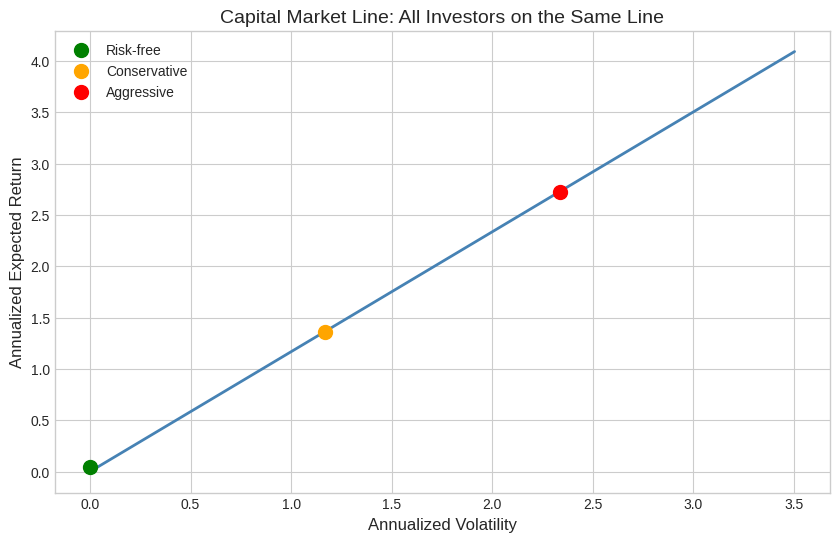

In [10]:
# Plot the Capital Market Line
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(frontier['Volatility'], frontier['Expected_Return'], linewidth=2, color='steelblue')
ax.scatter([0], [rf.mean() * 12], s=100, color='green', zorder=5, label='Risk-free')

# Mark some investor types
ax.scatter([frontier.iloc[33]['Volatility']], [frontier.iloc[33]['Expected_Return']],
           s=100, color='orange', zorder=5, label='Conservative')
ax.scatter([frontier.iloc[66]['Volatility']], [frontier.iloc[66]['Expected_Return']],
           s=100, color='red', zorder=5, label='Aggressive')

ax.set_xlabel('Annualized Volatility', fontsize=12)
ax.set_ylabel('Annualized Expected Return', fontsize=12)
ax.set_title('Capital Market Line: All Investors on the Same Line', fontsize=14)
ax.legend()
plt.show()

---

## Alpha Bets and Portable Alpha <a id="alpha-bets-and-portable-alpha"></a>

Most fund managers decompose their allocation into:
- **Factor bets**: Exposure to market, value, momentum, etc.
- **Alpha bets**: Hedged positions with zero factor exposure

For alpha strategies with:
- Alphas $\alpha$ (N×1)
- Factor betas $\beta$ (N×1)
- Idiosyncratic variance $\Sigma_\epsilon$

The optimal weights are:

$$W = \Sigma_\epsilon^{-1} \alpha$$

And the factor hedge:

$$W_f = -W'\beta$$

The factors hedge makes sure you have no factor exposure in your portfolio

> **🤔 Conceptual check:**
> Suppose you get two assets , you construct their hedged portfolios with respect to the market
> - what the covariance of these hedge portfolios look like?
> - What the covariance matrix look like?

In [11]:
# Estimate alpha and beta for each factor relative to the market
assets = ['SMB', 'HML', 'RMW', 'CMA', 'MOM']
market = 'Mkt-RF'

results = []
residuals_list = []

for asset in assets:
    X = sm.add_constant(df[market])
    y = df[asset]
    model = sm.OLS(y, X).fit()

    results.append({
        'Asset': asset,
        'Alpha (ann.)': model.params['const'] * 12,
        'Beta': model.params[market],
        'Idio Vol (ann.)': model.resid.std() * np.sqrt(12)
    })
    residuals_list.append(model.resid)

results_df = pd.DataFrame(results).set_index('Asset')
results_df.round(3)

,Alpha (ann.),Beta,Idio Vol (ann.)
Asset,,,
SMB,0.003,0.199,0.100
HML,0.044,-0.138,0.101
RMW,0.038,-0.094,0.076
CMA,0.041,-0.163,0.067
MOM,0.083,-0.162,0.142


In [12]:
# Compute the optimal alpha portfolio
Alpha = results_df['Alpha (ann.)'].values / 12  # Convert back to monthly
residuals_matrix = np.vstack(residuals_list).T
Sigma_eps = np.cov(residuals_matrix.T)
print(Sigma_eps)
# Optimal weights
W_alpha = np.linalg.inv(Sigma_eps) @ Alpha

print("Optimal alpha portfolio weights (unscaled):")
pd.Series(W_alpha, index=assets).round(2)

Optimal alpha portfolio weights (unscaled):


,0
SMB,3.25
HML,1.82
RMW,8.28
CMA,9.04
MOM,4.54


### Optimally Combining the hedged Portfolio  and the market

HERE! note that the new one has less content. Need to check!

- The hedged portfolio is constructed

$$$$
For two uncorrelated portfolios, the combined Sharpe ratio is:

$$SR_{combined} = \sqrt{SR_{market}^2 + SR_{alpha}^2}$$

In [13]:
# Compute hedged portfolio returns
hedged_returns = residuals_matrix @ W_alpha
hedged_er = hedged_returns.mean() * 12
hedged_vol = hedged_returns.std() * np.sqrt(12)
hedged_sr = hedged_er / hedged_vol

# Market stats
mkt_er = df[market].mean() * 12
mkt_vol = df[market].std() * np.sqrt(12)
mkt_sr = mkt_er / mkt_vol

# Combined
combined_sr = np.sqrt(mkt_sr**2 + hedged_sr**2)

print(f"Market Sharpe Ratio: {mkt_sr:.2f}")
print(f"Alpha Portfolio Sharpe (hedged): {hedged_sr:.2f}")
print(f"Combined Sharpe Ratio: {combined_sr:.2f}")

Market Sharpe Ratio: 0.46
Alpha Portfolio Sharpe (hedged): 0.00
Combined Sharpe Ratio: 0.46


---

## 📝 Exercises <a id="exercises"></a>

### Exercise 1: Warm-up — Optimal Weight for a Single Asset

> **🔧 Exercise:**
>
> For an investor with risk aversion $\gamma = 4$:
> 1. Compute the optimal weight for each factor **individually**
> 2. Compute the resulting portfolio volatility for each
> 3. Which factor would this investor allocate most to? Why?

In [ ]:
# Your code here
gamma = 4

<details>
<summary>💡 Click to see solution</summary>

```python
gamma = 4

for factor in factors.columns:
    mu_i = factors[factor].mean() * 12  # Annualized
    var_i = factors[factor].var() * 12  # Annualized
    
    x_star = (1 / gamma) * (mu_i / var_i)
    vol_port = abs(x_star) * factors[factor].std() * np.sqrt(12)
    
    print(f"{factor}: x* = {x_star:.2f}, Portfolio Vol = {vol_port:.2%}")
```
</details>

### Exercise 2: Extension — Target Volatility Portfolio

> **🤔 Think and Code:**
>
> You want a portfolio with **15% annualized volatility**.
> 1. Find the leverage $\lambda$ to apply to the MVE portfolio
> 2. Compute the expected return at this volatility level
> 3. What weights result for each factor?

In [ ]:
# Your code here
target_vol = 0.15

<details>
<summary>💡 Click to see solution</summary>

```python
target_vol = 0.15

# Current MVE vol (annualized)
mve_vol_ann = mve_vol * np.sqrt(12)

# Leverage to hit target
leverage = target_vol / mve_vol_ann
print(f"Required leverage: {leverage:.2f}")

# Scaled weights
W_target = leverage * W_mve
print(f"\nTarget weights:")
print(pd.Series(W_target, index=factors.columns).round(2))

# Expected return
target_er = (W_target @ mu) * 12
print(f"\nExpected return at {target_vol:.0%} vol: {target_er:.2%}")
```
</details>

### Exercise 3: Open-ended — Alpha + Beta Combination

> **🤔 Think and Code:**
>
> You have an alpha portfolio (hedged) and the market:
> 1. What fraction of your risk budget should go to each?
> 2. Use the formula: allocate proportionally to $SR^2$
> 3. If you target 20% total volatility, what are the individual volatilities?

In [ ]:
# Your code here

---

## 🧠 Key Takeaways <a id="key-takeaways"></a>

1. **Separate the two decisions** — First find the best risk-return portfolio, then decide how much risk to take

2. **MVE portfolio formula**: $W^* = \frac{1}{\gamma} \Sigma^{-1} E[R^e]$

3. **Two-fund separation** — All investors hold the same risky portfolio, just in different amounts

4. **Portable alpha** — Separate factor exposure from alpha by hedging out beta

5. **Appraisal ratio matters** — For adding to an existing portfolio, the hedged Sharpe ratio (appraisal ratio) is what counts

| Concept | Formula |
|---------|--------|
| Optimal weight | $x^* = \frac{1}{\gamma} \frac{E[r]}{\text{Var}(r)}$ |
| Optimal volatility | $x^* \sigma = \frac{SR}{\gamma}$ |
| MVE weights | $W = \Sigma^{-1} E[R^e]$ |
| Combined SR | $SR = \sqrt{SR_1^2 + SR_2^2}$ (if uncorrelated) |